1. Process 'dgsb_ad.xlsx'

In [27]:
import pandas as pd

# Load the Excel file
file_path = 'raw_data/dgsb_ad.xlsx'
xls = pd.ExcelFile(file_path)

# Column names as provided by the user
column_names = [
    'Date', 'PS_TS', 'PS_VS', 'PS_VS%', 'HM_in', 'M1_in', 'M1_temp', 'M1_pH', 
    'M1_TS', 'M1_VS', 'M1_VFA', 'M1_Alk', 'M1_Efficiency', 'M1_OLR', 'M1_HRT', 'M1_vol', 
    'M1_eff', 'M2_TS', 'M2_VS', 'M2_solids', 'M2_return', 'M2_eff', 'M2_up', 
    'M3_in', 'M3_pH', 'M3_TS', 'M3_VS', 'M3_VS%', 'M3_solids', 'M3_BOD', 'M3_TN', 
    'BP', 'BPR', 'CH4', 'CO2', 'H2S', 'deH2S', 'H2S_rm'
]

# Read and process each sheet
dfs = []
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name, skiprows=4, header=None)
    df.columns = column_names
    df = df.drop(columns=['PS_VS%', 'HM_in',
                          'M1_Efficiency', 'M1_OLR', 'M1_HRT', 
                          'M2_TS', 'M2_VS', 'M2_solids', 'M2_return', 'M2_eff', 'M2_up', 
                          'M3_in', 'M3_pH', 'M3_TS', 'M3_VS', 'M3_VS%', 'M3_solids', 'M3_BOD', 'M3_TN',
                          'BPR','deH2S', 'H2S_rm'])
    dfs.append(df)

# Concatenate all sheets vertically (axis=0)
concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
filtered_df = concatenated_df[~concatenated_df['Date'].astype(str).str.contains('평균|최대|최소', na=False)]
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'], format='%Y-%m-%d', errors='coerce')




/tmp/ipykernel_651675/3104363237.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Date'], format='%Y-%m-%d', errors='coerce')


2. Interpolate missing values in dgsb_ad

In [5]:
from scipy.interpolate import CubicSpline
import numpy as np

# Make a copy of dataframe to interpolate
interpolated_df = filtered_df.copy()

# For each numeric column, interpolate missing values using monotonic cubic spline (PCHIP is monotonic alternative to CubicSpline)
from scipy.interpolate import PchipInterpolator

# Identify numeric columns (except Date)
numeric_cols = interpolated_df.select_dtypes(include='number').columns

# Interpolate each column
for col in numeric_cols:
    # Get valid indices
    valid = ~interpolated_df[col].isna()
    if valid.sum() >= 2:  # Need at least 2 points to interpolate
        x = interpolated_df.loc[valid, 'Date'].map(pd.Timestamp.toordinal)
        y = interpolated_df.loc[valid, col]
        interpolator = PchipInterpolator(x, y)
        
        # Interpolate missing values
        missing = interpolated_df[col].isna()
        interpolated_df.loc[missing, col] = interpolator(interpolated_df.loc[missing, 'Date'].map(pd.Timestamp.toordinal))

interpolated_df['BPR'] = interpolated_df['BP'] / (interpolated_df['M1_in'] * interpolated_df['PS_VS']) * 1000
interpolated_df['MY'] = interpolated_df['BPR'] * interpolated_df['CH4'] / 100

interpolated_df.head()
interpolated_df.drop(columns=['BP', 'BPR', 'CH4'], inplace=True)
interpolated_df['Date'] = pd.to_datetime(interpolated_df['Date'], format='%Y-%m-%d', errors='coerce')
interpolated_df.index = interpolated_df['Date']
interpolated_df.drop(columns=['Date'], inplace=True)
interpolated_df.to_csv('dgsb_ad.csv')
print(interpolated_df.columns)
print(interpolated_df.shape)


Index(['PS_TS', 'PS_VS', 'M1_in', 'M1_temp', 'M1_pH', 'M1_TS', 'M1_VS',
       'M1_VFA', 'M1_Alk', 'M1_vol', 'M1_eff', 'CO2', 'H2S', 'MY'],
      dtype='object')
(1821, 14)


3. Visualization of dgsb_ad

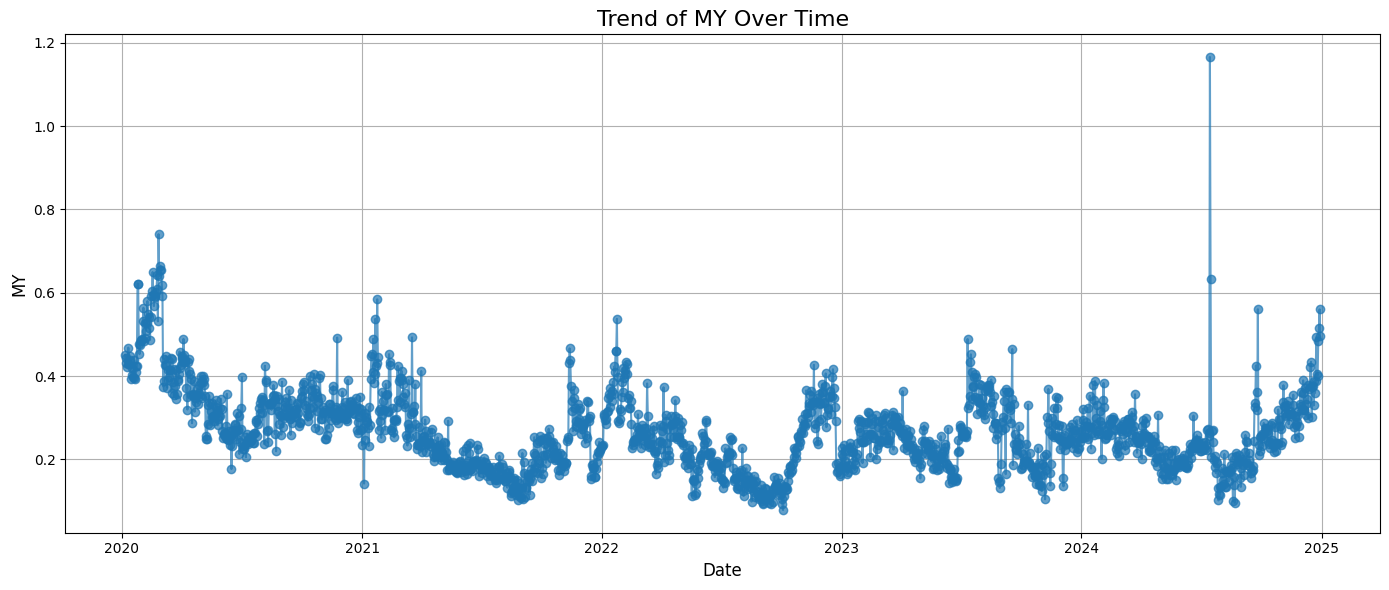

In [3]:
dgsb = pd.read_csv('dgsb_ad.csv', parse_dates=['Date'], index_col=0)
dgsb['Date'] = pd.to_datetime(dgsb['Date'], format='%Y-%m-%d', errors='coerce')
import matplotlib.pyplot as plt
# Plot MY trend over time
plt.figure(figsize=(14, 6))
plt.plot(dgsb['Date'], dgsb['MY'], marker='o', linestyle='-', alpha=0.7)
plt.title("Trend of MY Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("MY", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd

# Load the Excel file
file_path = 'raw_data/dgsh_ad.xlsx'
xls = pd.ExcelFile(file_path)

# Column names as provided by the user
column_names = [
    'Date', 'SL_vol', 'FW_in', 'PS_TS', 'PS_VS', 'PS_VS%', 
    'M1_in', 'M1_temp', 'M1_pH', 'M1_TS', 'M1_VS', 'M1_VS%', 'M1_VFA', 'M1_Alk', 'M1_Efficiency', 'M1_OLR', 'M1_HRT', 'M1_vol', 
    'M1_eff', 'M2_TS', 'M2_VS', 'M2_VS%', 'M2_solids', 'M2_return', 'M2_vol', 
    'BP', 'BPR', 'CH4', 'CO2', 'H2S', 'deH2S', 'H2S_rm'
]

# Read and process each sheet
dfs = []
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name, skiprows=4, header=None)
    df.columns = column_names
    df = df.drop(columns=['PS_VS%',
                          'M1_VS%', 'M1_Efficiency', 'M1_OLR', 'M1_HRT', 
                          'M2_TS', 'M2_VS', 'M2_VS%', 'M2_solids', 'M2_return', 'M2_vol',    
                          'BPR','deH2S', 'H2S_rm'])
    dfs.append(df)

# Concatenate all sheets vertically (axis=0)
concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
filtered_df = concatenated_df[~concatenated_df['Date'].astype(str).str.contains('평균|최대|최소', na=False)]
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'], format='%Y-%m-%d', errors='coerce')



In [3]:
from scipy.interpolate import CubicSpline
import numpy as np

# Make a copy of dataframe to interpolate
interpolated_df = filtered_df.copy()

# For each numeric column, interpolate missing values using monotonic cubic spline (PCHIP is monotonic alternative to CubicSpline)
from scipy.interpolate import PchipInterpolator

# Identify numeric columns (except Date)
numeric_cols = interpolated_df.select_dtypes(include='number').columns

# Interpolate each column
for col in numeric_cols:
    # Get valid indices
    valid = ~interpolated_df[col].isna()
    if valid.sum() >= 2:  # Need at least 2 points to interpolate
        x = interpolated_df.loc[valid, 'Date'].map(pd.Timestamp.toordinal)
        y = interpolated_df.loc[valid, col]
        interpolator = PchipInterpolator(x, y)
        
        # Interpolate missing values
        missing = interpolated_df[col].isna()
        interpolated_df.loc[missing, col] = interpolator(interpolated_df.loc[missing, 'Date'].map(pd.Timestamp.toordinal))

interpolated_df['BPR'] = interpolated_df['BP'] / (interpolated_df['M1_in'] * interpolated_df['PS_VS']) * 1000
interpolated_df['MY'] = interpolated_df['BPR'] * interpolated_df['CH4'] / 100

interpolated_df.head()
interpolated_df.drop(columns=['BP', 'BPR', 'CH4'], inplace=True)
interpolated_df['Date'] = pd.to_datetime(interpolated_df['Date'], format='%Y-%m-%d', errors='coerce')
interpolated_df.index = interpolated_df['Date']
interpolated_df.drop(columns=['Date'], inplace=True)
interpolated_df.to_csv('dgsh_ad.csv')
print(interpolated_df.columns)
print(interpolated_df.shape)


Index(['SL_vol', 'FW_in', 'PS_TS', 'PS_VS', 'M1_in', 'M1_temp', 'M1_pH',
       'M1_TS', 'M1_VS', 'M1_VFA', 'M1_Alk', 'M1_vol', 'M1_eff', 'CO2', 'H2S',
       'MY'],
      dtype='object')
(1826, 16)


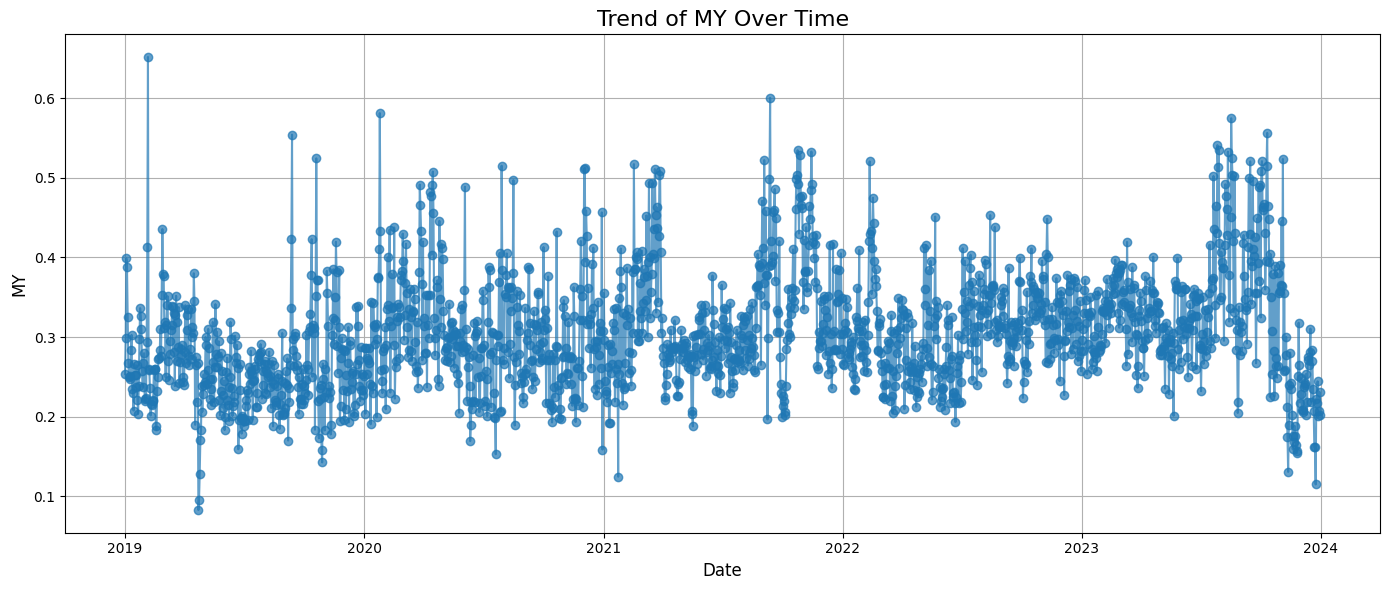

In [6]:
dgsh = pd.read_csv('dgsh_ad.csv', parse_dates=['Date'], index_col=0)
dgsh['Date'] = pd.to_datetime(dgsh['Date'], format='%Y-%m-%d', errors='coerce')
import matplotlib.pyplot as plt
# Plot MY trend over time
plt.figure(figsize=(14, 6))
plt.plot(dgsh['Date'], dgsh['MY'], marker='o', linestyle='-', alpha=0.7)
plt.title("Trend of MY Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("MY", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

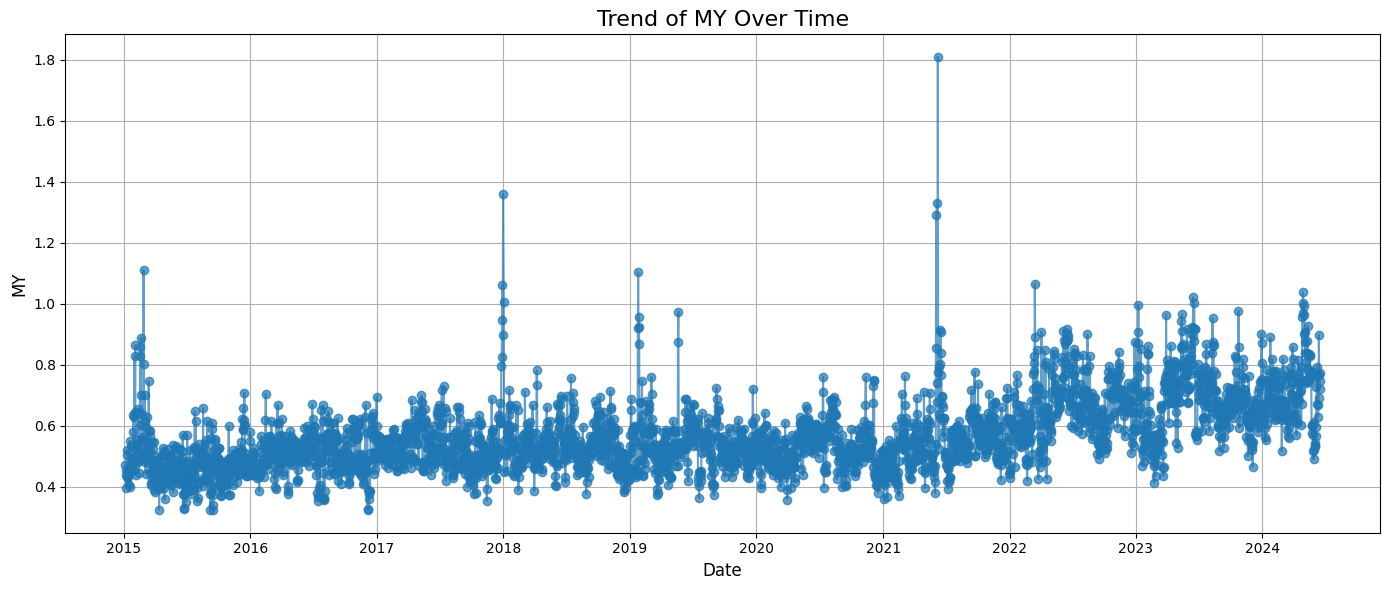

In [5]:
import pandas as pd

sbk = pd.read_csv('sbk_ad_selected.csv', parse_dates=['Date'])
sbk['Date'] = pd.to_datetime(sbk['Date'], format='%Y-%m-%d', errors='coerce')
import matplotlib.pyplot as plt
# Plot MY trend over time
plt.figure(figsize=(14, 6))
plt.plot(sbk['Date'], sbk['MY'], marker='o', linestyle='-', alpha=0.7)
plt.title("Trend of MY Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("MY", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

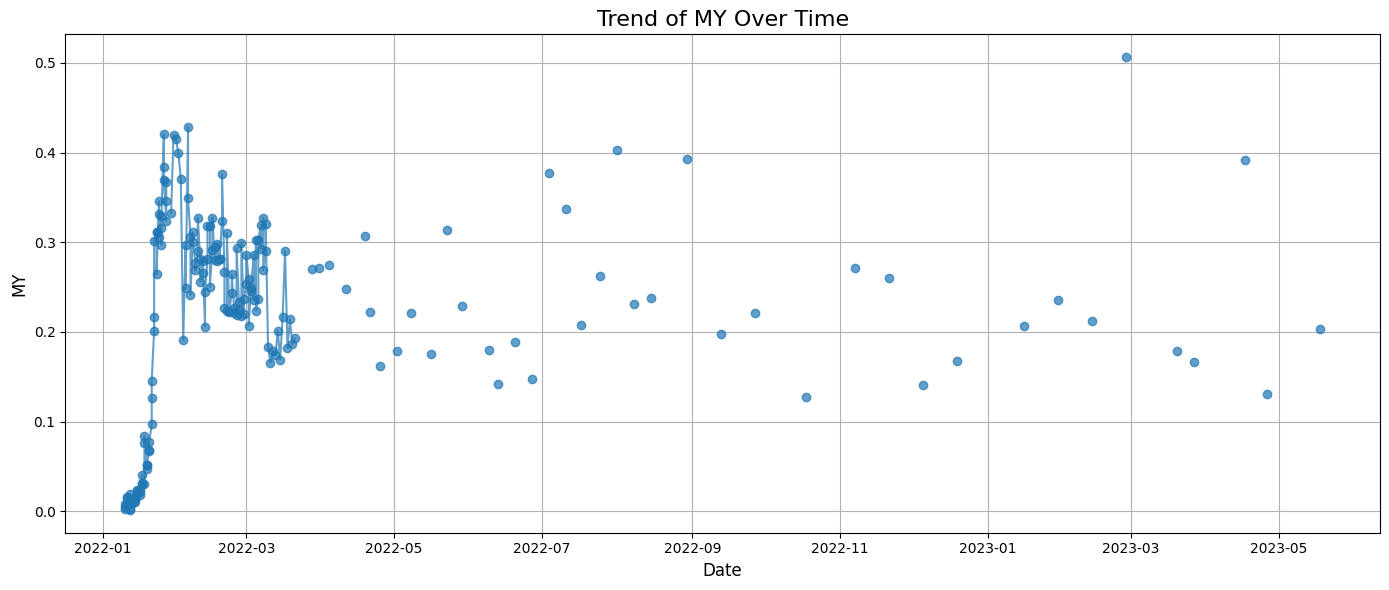

In [6]:
import pandas as pd

inoculum = pd.read_csv('inoculum.csv', parse_dates=['Date'])
inoculum['Date'] = pd.to_datetime(inoculum['Date'], format='%Y-%m-%d', errors='coerce')
import matplotlib.pyplot as plt
# Plot MY trend over time
plt.figure(figsize=(14, 6))
plt.plot(inoculum['Date'], inoculum['MY'], marker='o', linestyle='-', alpha=0.7)
plt.title("Trend of MY Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("MY", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 생곡 data

In [85]:
import pandas as pd
from openpyxl import load_workbook

# --- Settings ---
file_path = 'raw_data/bssg_ad.xlsx'
sheet_names = pd.ExcelFile(file_path).sheet_names
columns_to_remove = ['평균', '#3', '#4', '#5', '#6', '#7', '#8']
start_row = 14  # Row 15 in Excel (0-based index)
use_cols = 'B:BH'

# Load workbook to access merged headers
wb = load_workbook(file_path, data_only=True)

# --- Step 1: Process headers from first sheet (assuming consistent structure) ---
ws = wb[sheet_names[0]]
header_row1 = ws[15]  # Row 16 in Excel
header_row2 = ws[16]  # Row 17 in Excel

merged_headers = []
last_header = None
for cell1, cell2 in zip(header_row1[1:60], header_row2[1:60]):  # B to BH = columns 1 to 60
    top = cell1.value
    sub = cell2.value

    if top is None:
        top = last_header
    else:
        last_header = top

    # Merge with underscore, converting both to strings and replacing spaces with underscore if needed
    merged_header = str(top)
    if sub is not None:
        merged_header = f"{str(top).strip()}_{str(sub).strip()}"
    merged_headers.append(merged_header)
column_name = [
    'Date', 'temp_A', 'temp_B', 'pH_A', 'pH_B', 'VFA_A', 'VFA_B', 'Alk_A', 'Alk_B',
    'HRT', 'Q_in', 'TS_A', 'VS_A', 'VS/TS_A', 'FS/TS_A', 'eff', 
    'TS_B', 'VS_B', 'VS/TS_B', 'FS/TS_B', 'efficiency', 'sludge', 'CH4', 'CO2', 'H2S', 'etc','FW_Q_in',
    'BP', 'Boiler', 'Flare', 'Usage'
]

# Read and process each sheet
all_dfs = []
for sheet_name in xls.sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=start_row, header=None, usecols=use_cols)
    df.columns = merged_headers
     # Also read row 16 for filtering (2 rows to get row 16)
    df_check_row = pd.read_excel(file_path, sheet_name=sheet_name, header=None, skiprows=start_row, nrows=2, usecols=use_cols)
    second_header_row = df_check_row.iloc[1]

    # Filter columns based on row 16 values
    cols_to_keep = [col for col in merged_headers if not any(ex in col for ex in columns_to_remove)] 
    df = df[cols_to_keep]
    
    

    df.columns = column_name
    
    df = df.drop(columns=['Alk_A', 'Alk_B','VS/TS_A', 'FS/TS_A', 'eff',  'VS/TS_B', 'FS/TS_B', 'efficiency','sludge',
                          'CO2', 'etc', 'FW_Q_in', 'Boiler', 'Flare', 'Usage'])

    all_dfs.append(df)

    # 
# Concatenate all sheets vertically (axis=0)

concatenated_df = pd.concat(all_dfs, axis=0, ignore_index=True)
filtered_df = concatenated_df.dropna(subset=['Date'])
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'], format='%Y-%m-%d', errors='coerce')
filtered_df.dropna(subset='Date', inplace=True)
filtered_df.iloc[:,1:] = filtered_df.iloc[:,1:].apply(pd.to_numeric, errors='coerce')


filtered_df.to_csv('bssg_ad.csv') 

/tmp/ipykernel_651675/3310650944.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Date'], format='%Y-%m-%d', errors='coerce')
/tmp/ipykernel_651675/3310650944.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(subset='Date', inplace=True)


In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import PchipInterpolator

# Load data
interpolated_df = pd.read_csv('bssg_ad.csv', parse_dates=['Date'], index_col = 0)

# Ensure Date is datetime and set as index
interpolated_df['Date'] = pd.to_datetime(interpolated_df['Date'], errors='coerce')
interpolated_df.set_index('Date', inplace=True)
interpolated_df.iloc[0] = interpolated_df.iloc[0].fillna(interpolated_df.bfill().iloc[0])
interpolated_df.iloc[-1] = interpolated_df.iloc[-1].fillna(interpolated_df.ffill().iloc[-1])
# Interpolate numeric columns (except 'FW_VS' and 'MY' which are final outputs)
for col in interpolated_df.columns:
    if col not in ['FW_VS', 'MY']:
        # Apply ffill at start and bfill at end

        valid = ~interpolated_df[col].isna()
        if valid.sum() >= 2:
            x = interpolated_df.loc[valid].index.map(pd.Timestamp.toordinal)
            y = interpolated_df.loc[valid, col]
            interpolator = PchipInterpolator(x, y)
            missing = interpolated_df[col].isna()
            interpolated_df.loc[missing, col] = interpolator(interpolated_df.loc[missing].index.map(pd.Timestamp.toordinal))

# Recalculate FW_VS based on month
month = interpolated_df.index.month

def get_fw_vs(month):
    if 6 <= month <= 8:
        return 245
    elif 9 <= month <= 11:
        return 288
    elif month in [12, 1, 2]:
        return 177
    elif 3 <= month <= 5:
        return 174

interpolated_df['FW_VS'] = month.map(get_fw_vs)

# Recalculate MY if BP, CH4, and Q_in are present
required_cols = {'BP', 'CH4', 'Q_in'}
if required_cols.issubset(interpolated_df.columns):
    interpolated_df['BPR'] = interpolated_df['BP'] / (interpolated_df['Q_in'] * interpolated_df['FW_VS']) * 1000
    interpolated_df['MY'] = interpolated_df['BPR'] * interpolated_df['CH4'] / 100
    interpolated_df.drop(columns=['BP', 'BPR', 'CH4'], inplace=True)

interpolated_df['temp'] = interpolated_df['temp_A'] + interpolated_df['temp_B']
interpolated_df['pH'] = interpolated_df['pH_A'] + interpolated_df['pH_B']
interpolated_df['VFA'] = interpolated_df['VFA_A'] + interpolated_df['VFA_B']
interpolated_df['TS'] = interpolated_df['TS_A'] + interpolated_df['TS_B']
interpolated_df['VS'] = interpolated_df['VS_A'] + interpolated_df['VS_B']

interpolated_df.drop(['temp', 'pH', 'VFA', 'TS', 'VS'], axis = 1, inplace = True)

# Save and check
interpolated_df.to_csv('bssg_ad_processed.csv')
print(interpolated_df.columns)
print(interpolated_df.shape)


Index(['temp_A', 'temp_B', 'pH_A', 'pH_B', 'VFA_A', 'VFA_B', 'HRT', 'Q_in',
       'TS_A', 'VS_A', 'TS_B', 'VS_B', 'H2S', 'FW_VS', 'MY'],
      dtype='object')
(1827, 15)


In [88]:
interpolated_df.head()

,temp_A,temp_B,pH_A,pH_B,VFA_A,VFA_B,HRT,Q_in,TS_A,VS_A,TS_B,VS_B,H2S,FW_VS,MY
Date,,,,,,,,,,,,,,,
2020-01-01,38.0,40.0,7.880000,7.790000,1721.400000,1578.600000,74.097331,63.70,42.400000,34.683200,11.700000,7.100000,195.0,177,502.439933
2020-01-02,37.0,38.0,7.880000,7.790000,1721.400000,1578.600000,56.778540,83.13,42.400000,34.683200,11.700000,7.100000,204.0,177,159.693340
2020-01-03,36.0,37.0,7.880000,7.790000,1721.400000,1578.600000,54.290315,86.94,42.400000,34.683200,11.700000,7.100000,178.0,177,221.262492
2020-01-04,38.0,40.0,7.887778,7.795185,1722.219624,1580.791740,95.411360,49.47,41.214577,33.765871,11.712963,7.164815,70.0,177,14.561584
2020-01-05,40.0,40.0,7.902222,7.804815,1724.950358,1587.805701,84.710867,16.00,38.157434,31.400128,11.737037,7.285185,66.0,177,19.464407
